# Visualisation of inference results
Test years: 2018-2022 (included)

### Utils

In [6]:
import numpy as np 
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs

In [7]:
def plot_map(lats, lons, data, name):
    plt.figure(figsize=(20, 5))
    buffer = 0.01
    ax = plt.axes(projection=ccrs.PlateCarree())
    # Calculate extent with buffer to avoid identical limits
    lon_min, lon_max = lons.min(), lons.max()
    lat_min, lat_max = lats.min(), lats.max()
    # extent = [lon_min, lon_max, lat_min - buffer, lat_max + buffer]
    
    # ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.coastlines()
    
    # Plot data
    im = ax.imshow(data, origin='lower', extent=[lon_min, lon_max, lat_min, lat_max], transform=ccrs.PlateCarree(), cmap='viridis')
    plt.colorbar(im, label=name, extend='both')
    ax.gridlines(draw_labels=True)
    plt.show()
    

### Visualize CRPS

In [8]:
def plot_crps_var(variable, projection=ccrs.PlateCarree()):
    index2month = {1: "January", 2: "February", 3: "March", 4: "April", 5: "May", 6: "June", 7: "July", 8: "August", 9: "September", 10: "October", 11: "November", 12: "December"}
    base_dir = "training_results/spatial_month"
    if variable == "2m_temperature":
        train_index = 2
    else:
        train_index = 3

    # Determine the min and max CRPS values
    min_crps, max_crps = float('inf'), -float('inf')
    for month in range(1, 13):
        file_path = f"{base_dir}/training_{train_index}_spatial_month{month}_{variable}_lead=28/crps_{14}.nc"
        train_index += 2
        eval_data = xr.open_dataset(file_path)

        if variable == "2m_temperature":
            name_var = variable[3:]
        else:
            name_var = variable[4:]
        crps = eval_data[f"crps_{name_var}"].mean(axis=0)
        
        min_crps = min(min_crps, crps.min())
        max_crps = max(max_crps, crps.max())

    # normalize accross all months
    # TODO : adapt normalization to the data
    norm = plt.Normalize(vmin=min_crps, vmax=max_crps/2)

    # second loop to plot
    if variable == "2m_temperature":
        train_index = 2
    else:
        train_index = 3

    fig, axes = plt.subplots(4, 3, figsize=(20, 15), subplot_kw={'projection': projection})
    fig.suptitle(f"CRPS for {variable}")
    for month in range(1,13):
        # get month data 
        file_path = f"{base_dir}/training_{train_index}_spatial_month{month}_{variable}_lead=28/crps_{14}.nc"
        train_index += 2
        print(file_path)
        eval_data = xr.open_dataset(file_path)
        lats = eval_data.latitude.values
        lons = eval_data.longitude.values
        lon_min, lon_max = lons.min(), lons.max()
        lat_min, lat_max = lats.min(), lats.max()

        if variable == "2m_temperature":
            name_var = variable[3:]
        else:
            name_var = variable[4:]
        crps = eval_data[f"crps_{name_var}"].mean(axis=0)

        # plot 
        ax = axes[(month-1)//3, (month-1)%3]
        ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
        ax.coastlines()
        im = ax.imshow(crps, origin='lower', extent=[lon_min, lon_max, lat_min, lat_max], transform=ccrs.PlateCarree(), cmap='viridis', norm=norm)
        ax.set_title(f"{index2month[month]}")

    # Add a colorbar that spans all subplots
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    fig.colorbar(im, cax=cbar_ax, label="CRPS", extend='both', norm=norm)
    plt.show()



training_results/spatial_month/training_2_spatial_month1_2m_temperature_lead=28/crps_14.nc
training_results/spatial_month/training_4_spatial_month2_2m_temperature_lead=28/crps_14.nc
training_results/spatial_month/training_6_spatial_month3_2m_temperature_lead=28/crps_14.nc
training_results/spatial_month/training_8_spatial_month4_2m_temperature_lead=28/crps_14.nc
training_results/spatial_month/training_10_spatial_month5_2m_temperature_lead=28/crps_14.nc
training_results/spatial_month/training_12_spatial_month6_2m_temperature_lead=28/crps_14.nc
training_results/spatial_month/training_14_spatial_month7_2m_temperature_lead=28/crps_14.nc
training_results/spatial_month/training_16_spatial_month8_2m_temperature_lead=28/crps_14.nc
training_results/spatial_month/training_18_spatial_month9_2m_temperature_lead=28/crps_14.nc
training_results/spatial_month/training_20_spatial_month10_2m_temperature_lead=28/crps_14.nc
training_results/spatial_month/training_22_spatial_month11_2m_temperature_lead=28/c

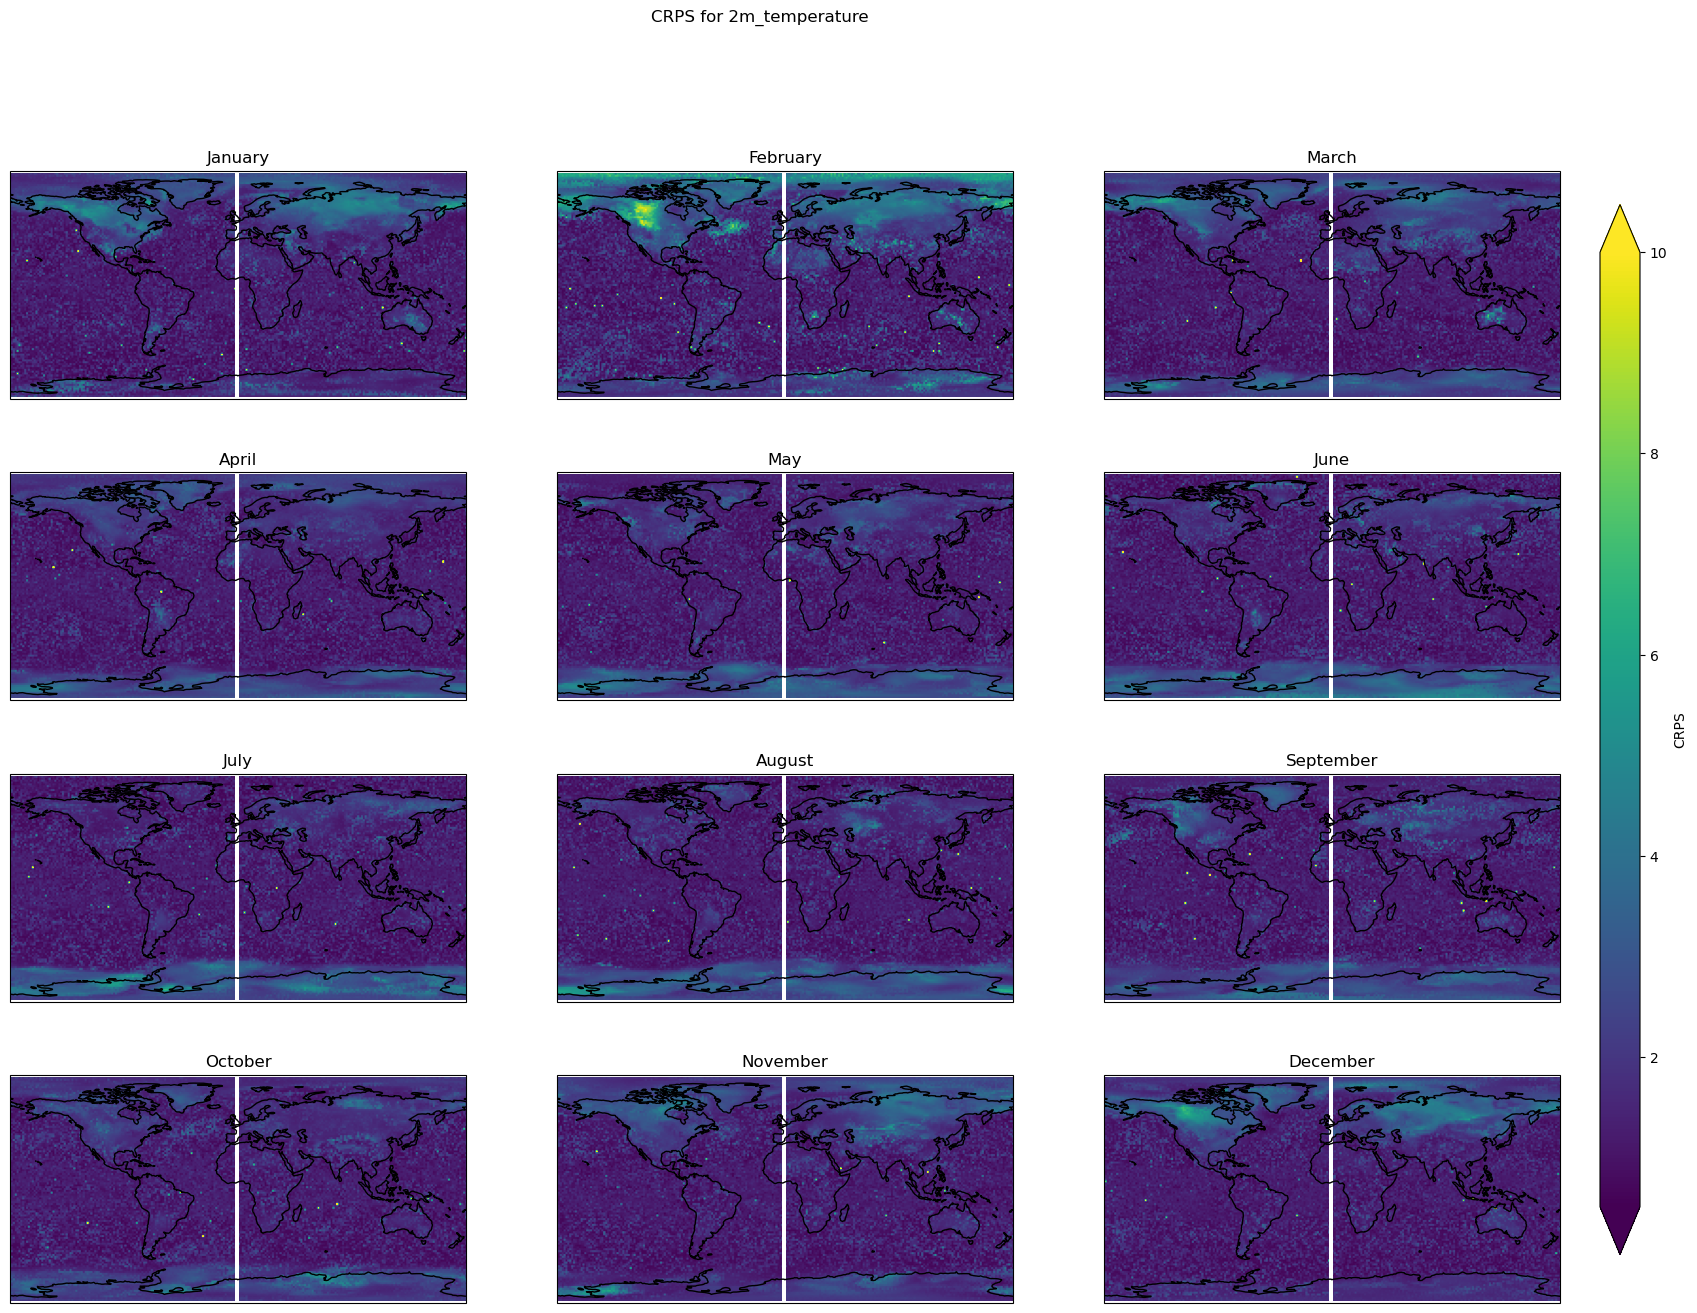

In [9]:
plot_crps_var("2m_temperature")

### Visualize mean and std fields 

In [14]:
from processings.dataset import WeatherDataset
from torch.utils.data import DataLoader
from model import SpatialMOS
from metrics import compute_crps_normal
import torch

def compute_inference(variable, train_index, month, projection=ccrs.PlateCarree()):
    index2month = {1: "January", 2: "February", 3: "March", 4: "April", 5: "May", 6: "June", 7: "July", 8: "August", 9: "September", 10: "October", 11: "November", 12: "December"}
    base_dir = "training_results/spatial_month"

    data_folder = "/home/majanvie/scratch/data/raw"
    test_folder = f"{data_folder}/test"
    obs_folder = f"{data_folder}/obs"
    lead_time = 28
    epoch=14
    valid_years = [2018,2022]
    model_folder = f"{base_dir}/training_{train_index}_spatial_month{month}_{variable}_lead={lead_time}"

    test_dataset = WeatherDataset(
        data_path=test_folder,
        obs_path=obs_folder,
        target_variable=variable,
        lead_time_idx=lead_time,
        valid_years=valid_years,
        valid_months=[month,month],
        subset="test")
    print(len(test_dataset.data_index))
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

    # load model weights
    model = SpatialMOS(47, 121, 240, 3)
    model.load_state_dict(torch.load(
        f"{model_folder}/model_{epoch}.pth"
        ))
    model.eval()

    # Compute performance metrics
    m_list = []
    std_list =[]
    crps_list = []
    for batch in test_loader:
        mu = batch['mu']
        sigma = batch['sigma']
        X = batch['input']
        y = batch['truth']
        out_distrib = model(mu, sigma, X, y)
        
        # get mean, std of distrib 
        mean = out_distrib.loc
        std = out_distrib.scale
        m_list.append(mean)
        std_list.append(std)
        
        crps_var = compute_crps_normal(model, batch).detach().numpy()  # shape (1, lat, lon)
        crps_list.append(crps_var)
    return m_list, std_list, crps_list, test_dataset
    

def plot_best_worst(m_list, std_list, crps_list, test_dataset, variable):
    lats = test_dataset.latitude
    lons = test_dataset.longitude

    # get best and worst crps indices 
    crps_list_mean = [crps.mean() for crps in crps_list]
    bad_index = np.argmax(crps_list_mean)
    best_index = np.argmin(crps_list_mean)

    # plot 
    fig, axes = plt.subplots(2, 2, figsize=(20, 15), subplot_kw={'projection': ccrs.PlateCarree()})
    fig.suptitle(f"Mean, STD of best and worst CRPS for {variable}")
    data_list = [m_list[bad_index], m_list[best_index], std_list[bad_index], std_list[best_index]]
    min_mean, max_mean = min([data.min() for data in data_list[:3]]), max([data.max() for data in data_list[:3]])
    min_std, max_std = min([data.min() for data in data_list[3:]]), max([data.max() for data in data_list[3:]])
    norm_mean = plt.Normalize(vmin=min_mean, vmax=max_mean)
    if variable == "2m_temperature":
        norm_mean = plt.Normalize(vmin=220, vmax=330)
    norm_std = plt.Normalize(vmin=min_std, vmax=max_std)

    for i, data in enumerate(data_list):
        ax = axes[i//2, i%2]
        ax.set_extent([lons.min(), lons.max(), lats.min(), lats.max()], crs=ccrs.PlateCarree())
        ax.coastlines()
        
        if i < 2:
            im = ax.imshow(data.detach().numpy()[0], origin='lower', extent=[lons.min(), lons.max(), lats.min(), lats.max()],
            transform=ccrs.PlateCarree(), cmap='viridis', norm=norm_mean)
            ax.set_title(f"Mean of {variable} for {['worst', 'best'][i%2]} CRPS")
        else:
            im = ax.imshow(data.detach().numpy()[0], origin='lower', extent=[lons.min(), lons.max(), lats.min(), lats.max()],
            transform=ccrs.PlateCarree(), cmap='viridis', norm=norm_std)
            ax.set_title(f"STD of {variable} for {['worst', 'best'][i%2]} CRPS")

        # Add colorbars for each row of subplots
        if i ==1:
            cbar_ax_mean = fig.add_axes([0.92, 0.55, 0.02, 0.35])  # [left, bottom, width, height]
            cbar_mean = fig.colorbar(im, cax=cbar_ax_mean, label="Mean " + variable, extend='both', norm=norm_mean)
        elif i == 3:
            cbar_ax_std = fig.add_axes([0.92, 0.1, 0.02, 0.35])  # [left, bottom, width, height]
            cbar_std = fig.colorbar(im, cax=cbar_ax_std, label="STD " + variable, extend='both', norm=norm_std)

    plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to accommodate colorbars
    plt.show()




44


/tmp/ipykernel_40028/1721621163.py:101: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to accommodate colorbars


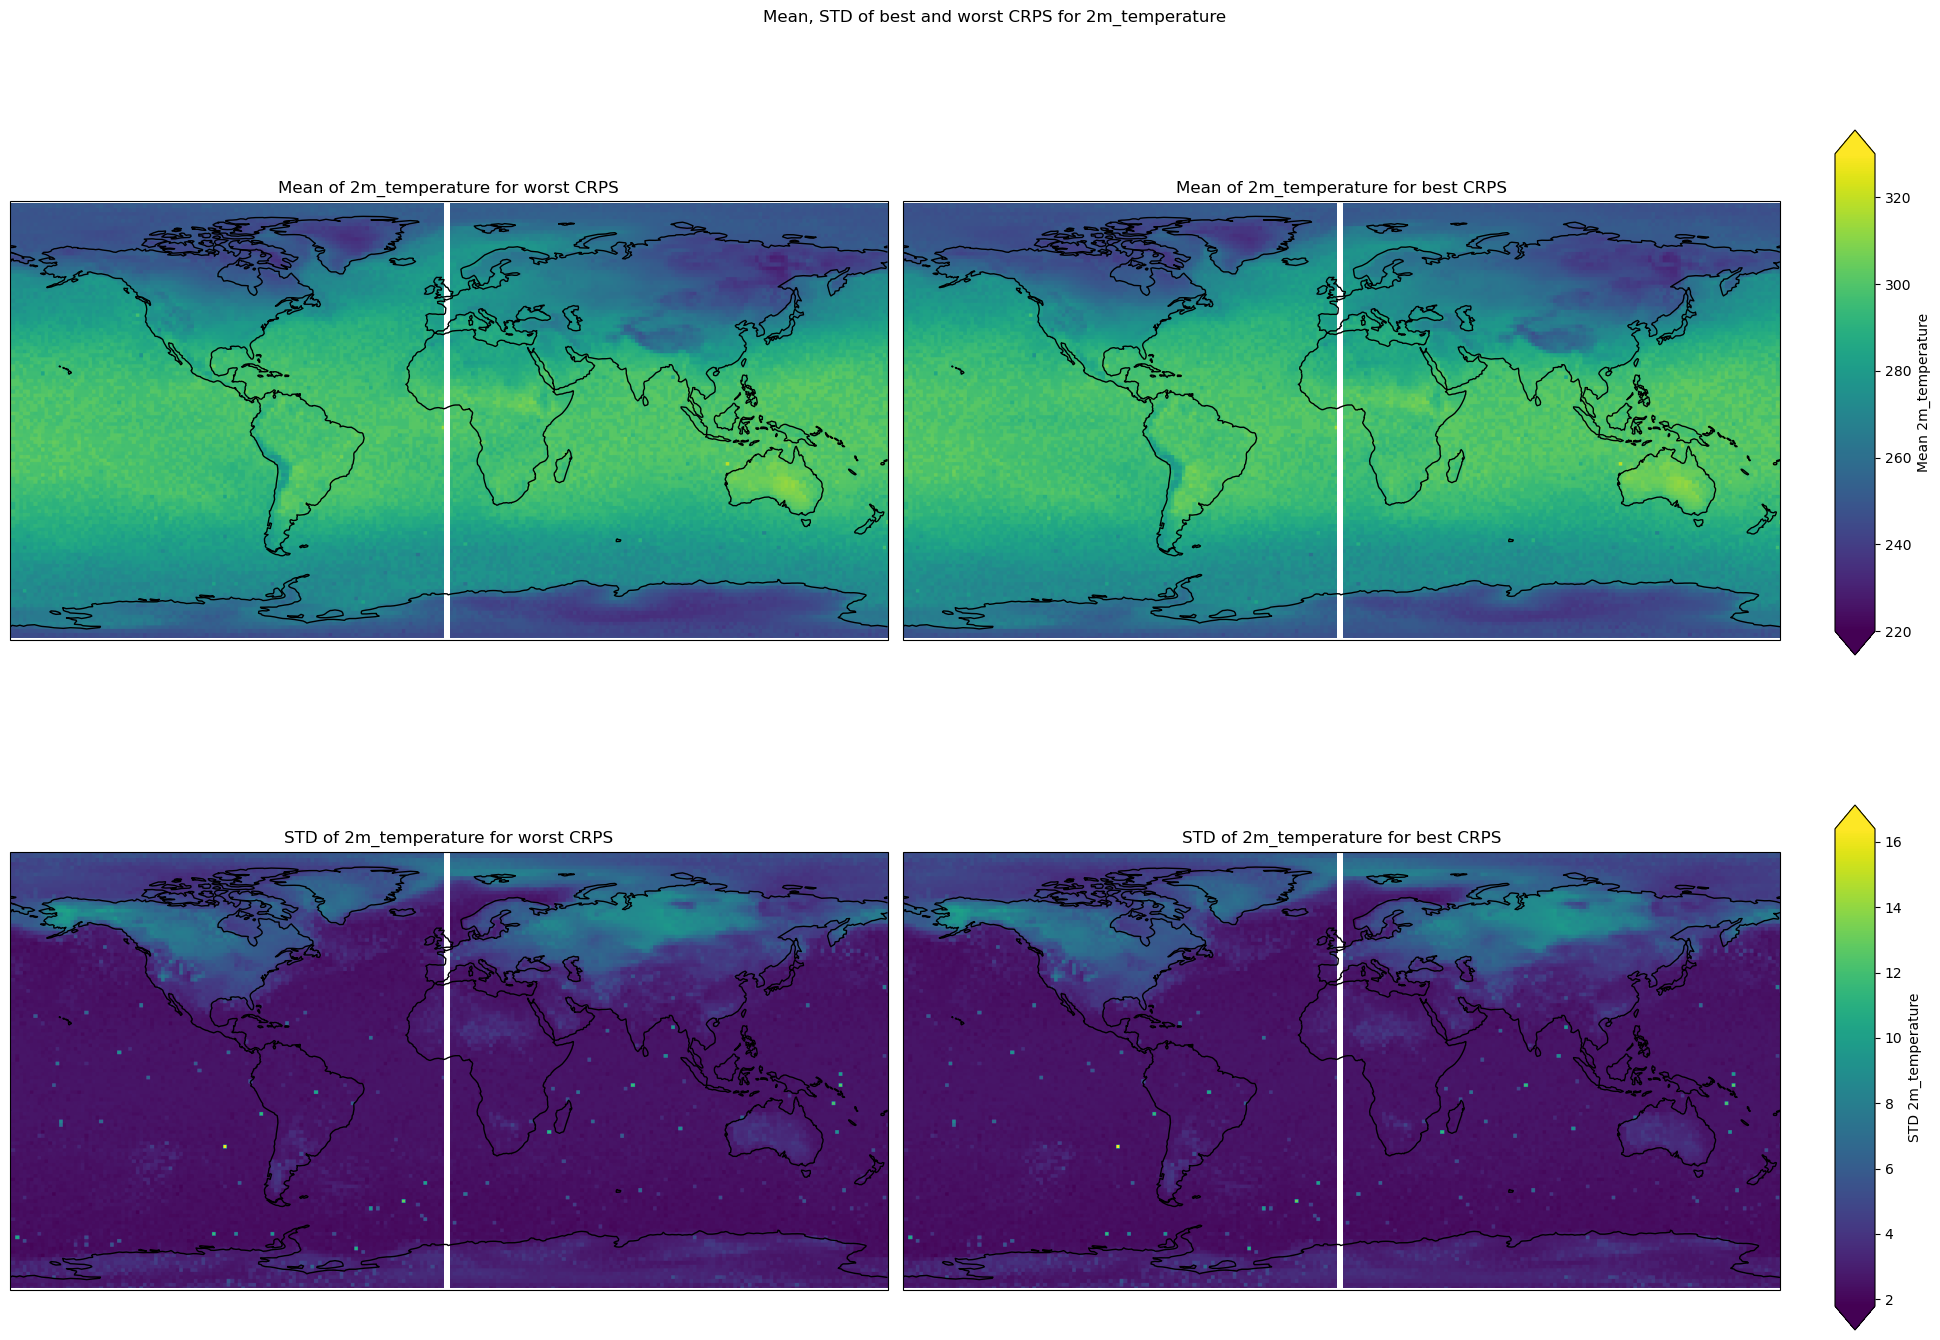

In [15]:
m_list, std_list, crps_list, test_dataset = compute_inference("2m_temperature", 2, 1)
plot_best_worst(m_list, std_list, crps_list, test_dataset, "2m_temperature")